### Phase1: Collecting Required Packages and Dataset

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score


In [20]:
data = pd.read_csv("C:/Users/Mohan/Documents/___.__/Project/NZDUSD.csv")

### Phase2: Preprocessing

In [21]:
data['Date'] = pd.to_datetime(data["Date"], format='%d/%m/%Y %H:%M:%S')
# data= data.set_index(["Date"], drop=False)

In [22]:
data['Date']=data.Date.apply(lambda x: str(x).split(" ")[0])

In [23]:
data['Date'] = pd.to_datetime(data['Date'])

<AxesSubplot: >

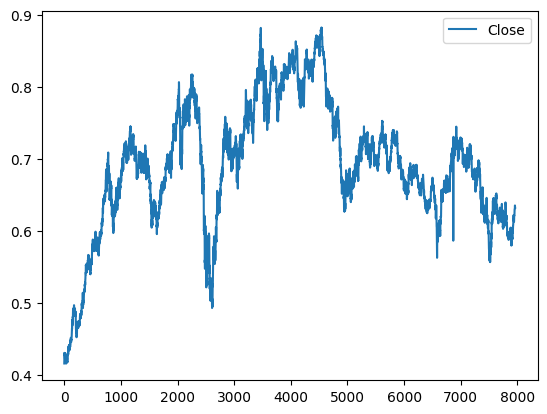

In [24]:
data.plot(y='Close')

In [25]:
data['Date'].sort_values()

0      2002-01-01
1      2002-01-02
2      2002-01-03
3      2002-01-04
4      2002-01-05
          ...    
7958   2023-12-27
7959   2023-12-28
7960   2023-12-29
7961   2023-12-30
7962   2023-12-31
Name: Date, Length: 7963, dtype: datetime64[ns]

In [26]:
data.head()

,Date,Close
0,2002-01-01,0.4155
1,2002-01-02,0.4228
2,2002-01-03,0.4253
3,2002-01-04,0.4302
4,2002-01-05,0.4288


In [27]:
data.tail()

,Date,Close
7958,2023-12-27,0.634890
7959,2023-12-28,0.633455
7960,2023-12-29,0.632400
7961,2023-12-30,0.632400
7962,2023-12-31,0.631835


In [28]:
data.describe()

,Close
count,7963.000000
mean,0.690308
std,0.089277
min,0.415500
25%,0.640500
50%,0.692700
75%,0.745170
max,0.882000


In [29]:
split_date = pd.Timestamp('01-01-2019')

test = data[data['Date']>=split_date]
train = data[data['Date']<split_date]
print(len(train),len(test))


6137 1826


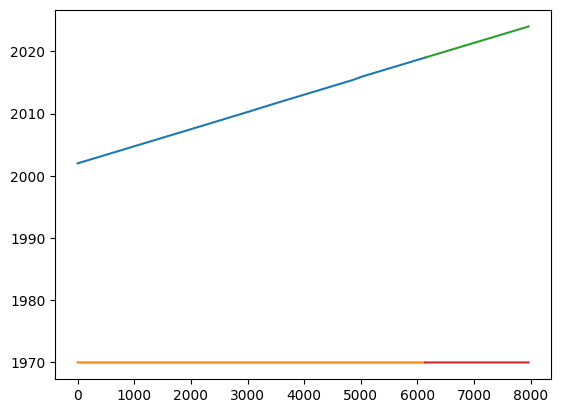

In [30]:
plt.plot(train)
plt.plot(test)

In [31]:
train=train.drop(['Date'],axis=1)
test=test.drop(['Date'],axis=1)

In [32]:
"""sc=MinMaxScaler()
train=sc.fit_transform(train)
test=sc.fit_transform(test)
train=np.array(train)
test=np.array(test)
train=pd.DataFrame(train)
test=pd.DataFrame(test)"""

'sc=MinMaxScaler()\ntrain=sc.fit_transform(train)\ntest=sc.fit_transform(test)\ntrain=np.array(train)\ntest=np.array(test)\ntrain=pd.DataFrame(train)\ntest=pd.DataFrame(test)'

### Phase3: LSTM layer

In [33]:
# Define and train LSTM model
def create_lstm_model(input_shape):
    look_back = 10
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))  # Hyperparameter: Number of LSTM units
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def train_lstm_model(train_data):
    X_train, y_train = [], []
    for i in range(len(train_data)-11):
        X_train.append(train_data.iloc[i:i+10])
        y_train.append(train_data.iloc[i+11])
    X_train, y_train = np.array(X_train), np.array(y_train)
    print(X_train.shape,y_train.shape)
    model = create_lstm_model(X_train.shape[1:])
    model.summary()
    model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=0)
    
    return model

lstm_model = train_lstm_model(train)




(6126, 10, 1) (6126, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
# Make predictions using LSTM model
def lstm_forecast(model, test_data):
    X_test, y_test = [], []
    for i in range(len(test_data)-11):
        X_test.append(test_data.iloc[i:i+10])
        y_test.append(test_data.iloc[i+11])
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    y_pred = model.predict(X_test, verbose=0)
    return y_pred, y_test

lstm_predictions, y_test = lstm_forecast(lstm_model,test)

### Phase4: ARIMA layer

In [42]:
# Calculate residuals (difference between actual values and LSTM predictions)
residuals = y_test - lstm_predictions

# Train ARIMA model on residuals
arima_model = ARIMA(residuals, order=(5,1,0))
arima_model_fit = arima_model.fit()

# Make predictions using ARIMA model
arima_predictions = arima_model_fit.forecast(steps=len(y_test))
arima_predictions=arima_predictions.reshape(-1,1)
# Combine forecasts from LSTM and ARIMA
hybrid_forecast = lstm_predictions + arima_predictions

c:\Users\Mohan\anaconda3\envs\base_2\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [43]:
lstm_predictions.shape

(1815, 1)

In [44]:
arima_predictions.shape

(1815, 1)

In [45]:
hybrid_forecast.shape

(1815, 1)

In [46]:
mae_lstm = mean_absolute_error(lstm_predictions,y_test)
mae_arima =mean_absolute_error(arima_predictions, y_test)
mae_hybrid =mean_absolute_error(hybrid_forecast,y_test)
mse_lstm = mean_squared_error(lstm_predictions,y_test)
mse_arima =mean_squared_error(arima_predictions, y_test)
mse_hybrid =mean_squared_error(hybrid_forecast,y_test)
rmse_lstm = np.sqrt(mean_squared_error(lstm_predictions,y_test))
rmse_arima =np.sqrt(mean_squared_error(arima_predictions, y_test))
rmse_hybrid =np.sqrt(mean_squared_error(hybrid_forecast,y_test))
r2_lstm = r2_score(lstm_predictions,y_test)
r2_arima =r2_score(arima_predictions, y_test)
r2_hybrid =r2_score(hybrid_forecast,y_test)

### phase5: Result and Conclusions

Mean Absolute Error (LSTM)  : 0.004808909098443908
Mean Absolute Error (RF)    : 0.6555057263549648
Mean Absolute Error (Hybrid): 0.004251835891943999

Mean Squared Error (LSTM)  : 7.248718041353594e-05
Mean Squared Error (RF)    : 0.4312700492443026
Mean Squared Error (Hybrid): 6.610279003014701e-05

Root Mean Squared Error (LSTM)  : 0.00851394035764498
Root Mean Squared Error (RF)    : 0.6567115418844888
Root Mean Squared Error (Hybrid): 0.008130362232406808

r2_score (LSTM)  : 0.9540755580987903
r2_score (RF)    : -363420209.82698494
r2_score (Hybrid): 0.9581209513579945


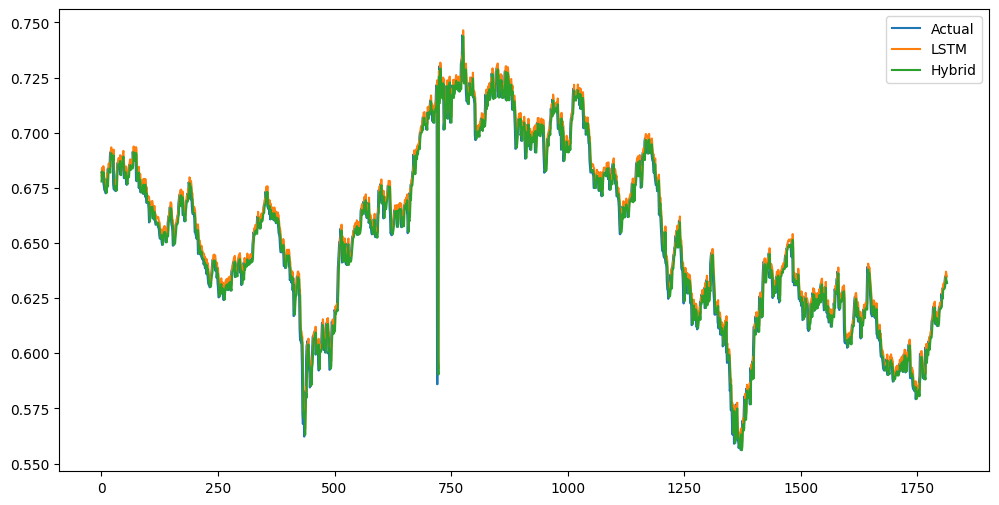

In [47]:
print("Mean Absolute Error (LSTM)  :", mae_lstm)
print("Mean Absolute Error (RF)    :", mae_arima)
print("Mean Absolute Error (Hybrid):", mae_hybrid)
print("")
print("Mean Squared Error (LSTM)  :", mse_lstm)
print("Mean Squared Error (RF)    :", mse_arima)
print("Mean Squared Error (Hybrid):", mse_hybrid)
print("")
print("Root Mean Squared Error (LSTM)  :", rmse_lstm)
print("Root Mean Squared Error (RF)    :", rmse_arima)
print("Root Mean Squared Error (Hybrid):", rmse_hybrid)
print("")
print("r2_score (LSTM)  :", r2_lstm)
print("r2_score (RF)    :", r2_arima)
print("r2_score (Hybrid):", r2_hybrid)

# Plot forecasts
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(lstm_predictions, label='LSTM')
#plt.plot(arima_predictions, label='ARIMA')
plt.plot(hybrid_forecast, label='Hybrid')
plt.legend()
plt.show()

In [48]:
final_predictions=np.array(hybrid_forecast)
final_predictions=pd.DataFrame(final_predictions)
final_predictions.to_csv('LSTIM_ARIMA_NZDUSD.csv', index=False)

In [ ]:
hybrid_forecast,y_test

(array([[0.67786515],
        [0.68220624],
        [0.68176427],
        ...,
        [0.63445256],
        [0.63324962],
        [0.63212107]]),
 array([[0.682   ],
        [0.6819  ],
        [0.68251 ],
        ...,
        [0.6324  ],
        [0.6324  ],
        [0.631835]]))